In [1]:
from tools.propagate import create_photon_propagator
from tools.geometry import generate_detector
from tools.utils import load_single_event, save_single_event, print_params, generate_random_params
from tools.losses import compute_loss_with_time
from tools.simulation import setup_event_simulator

import jax
import jax.numpy as jnp
import time

from jax import jit

# uncomment to run on CPU
# jax.config.update('jax_platform_name', 'cpu')

In [16]:
default_json_filename = 'config/cyl_geom_config.json'

detector = generate_detector(default_json_filename)
detector_points = jnp.array(detector.all_points)
detector_radius = detector.S_radius
NUM_DETECTORS = len(detector_points)
Nphot = 1_000_000

# temperature is the relaxation used for overlap probability.
temperature = None
temperature_sim = 0.2

In [17]:
# is_data=True sets t0 = 0
simulate_true_data = setup_event_simulator(default_json_filename, Nphot, temperature, is_data=True)
simulate_event = setup_event_simulator(default_json_filename, Nphot, temperature_sim)

In [18]:
# Generate and save a single event
key = jax.random.PRNGKey(71900)

# Sample true parameter configurations:

# cone on the wall
true_params = (
    jnp.array(30.0),  # opening angle
    jnp.array([0.5, 0.0, -0.5]),  # position
    jnp.array([1.0, -1.0, 0.2]),  # direction
    jnp.array(5000.0)  # intensity
)

# fully open cone along the wall
true_params = (
    jnp.array(90.0),  # opening angle
    jnp.array([0.0, 0.0, 0.0]),  # position
    jnp.array([0.0, 1.0, 0.0]),  # direction
    jnp.array(5000.0)  # intensity
)

# Generate random parameters
true_params = generate_random_params(key)

single_event_data = simulate_event(true_params, key)

save_single_event(single_event_data, true_params, filename='events/test_event_data.h5')

'events/test_event_data.h5'

In [19]:
%%timeit

# get a random key from time
key = jax.random.PRNGKey(int(time.time()))

true_params = generate_random_params(key)

single_event_data = simulate_event(true_params, key)

5.42 ms ± 1.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Event Parameters:
────────────────────
Opening Angle: 45.32 degrees
Initial Position: (0.59, 0.00, 0.66)
Initial Direction: (0.53, 0.60, -0.63)
Initial Intensity: 8.33
────────────────────


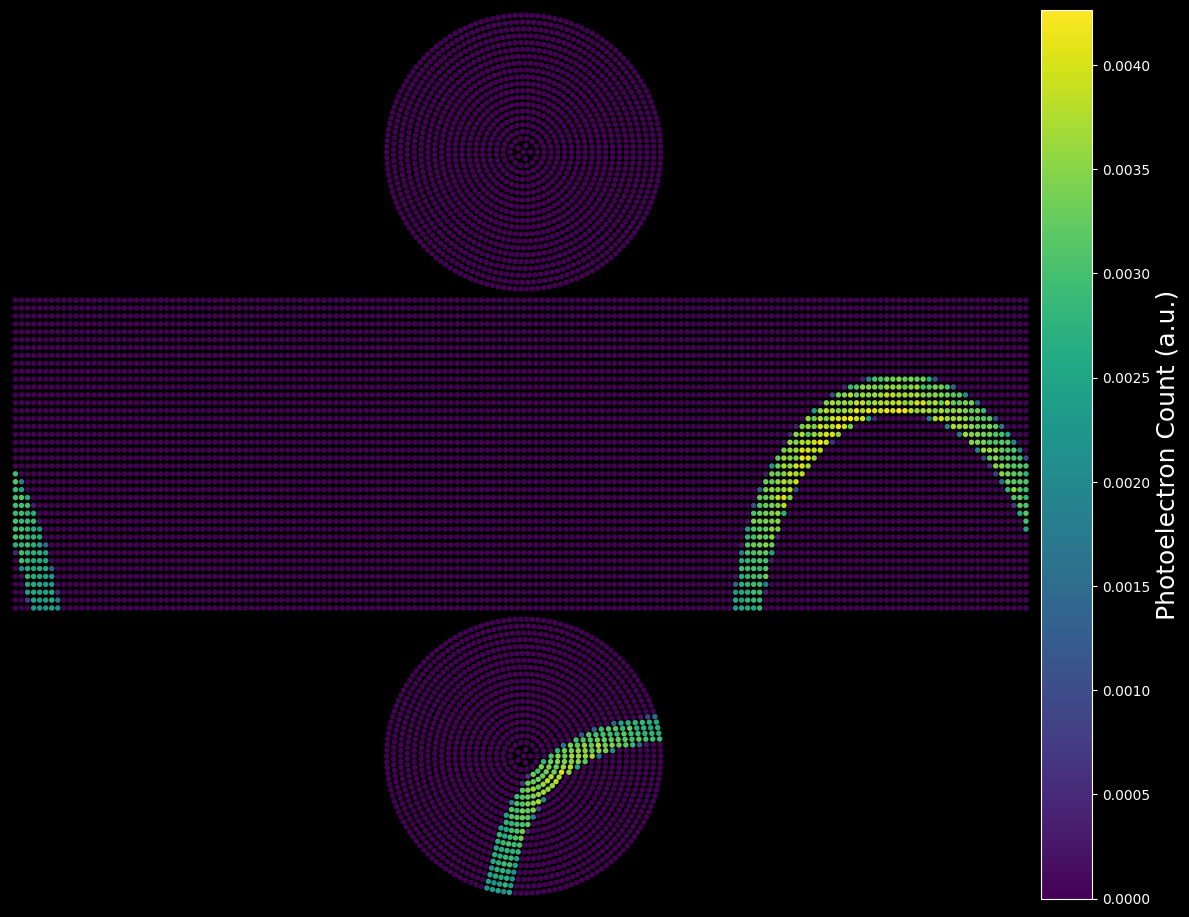

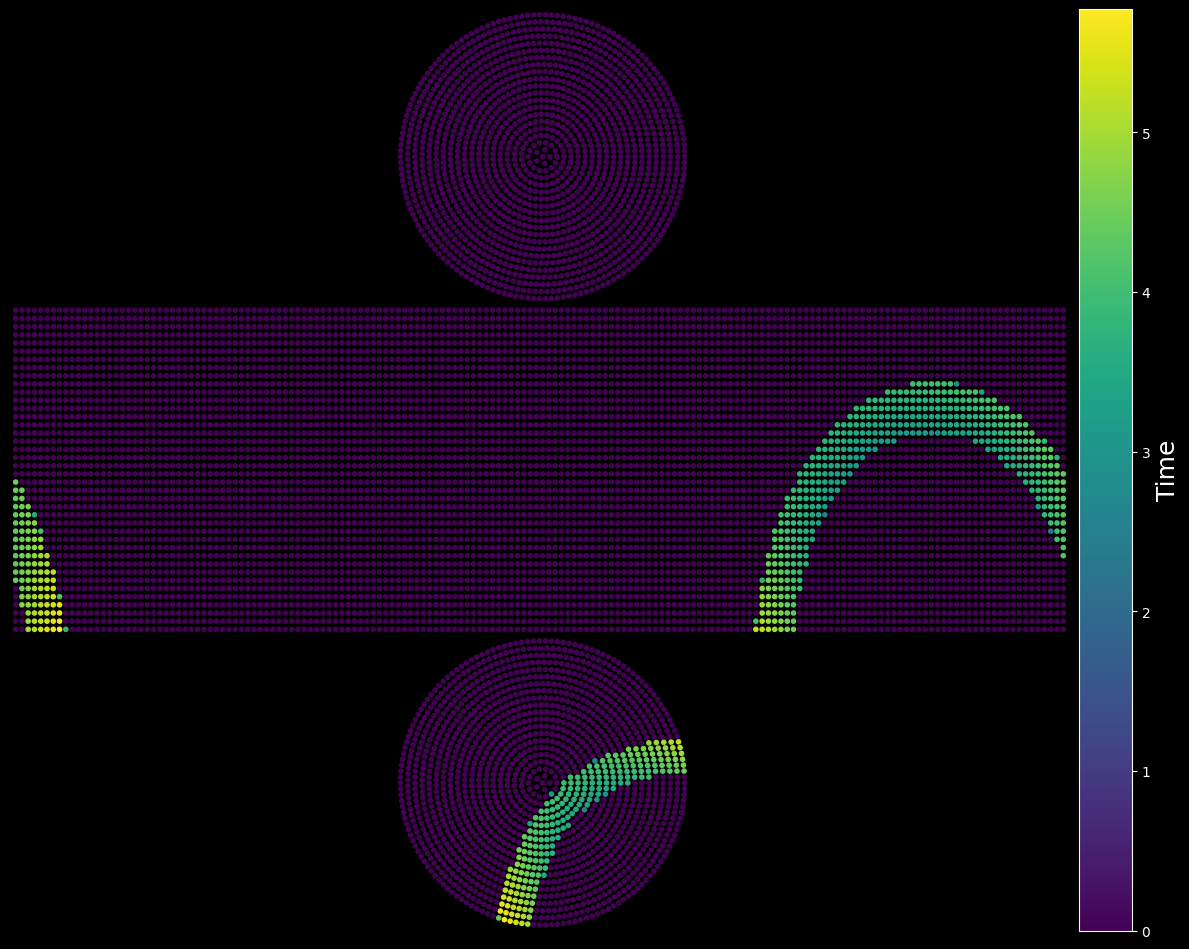

In [20]:
from tools.visualization import create_detector_display
event_location = 'events/test_event_data.h5'
loaded_params, loaded_indices, loaded_charges, loaded_times = load_single_event(event_location, NUM_DETECTORS)
print_params(loaded_params)

detector_display = create_detector_display()
detector_display(loaded_indices, loaded_charges, loaded_times, file_name='event_display.png', plot_time=False)
detector_display(loaded_indices, loaded_charges, loaded_times, file_name='event_display.png', plot_time=True)

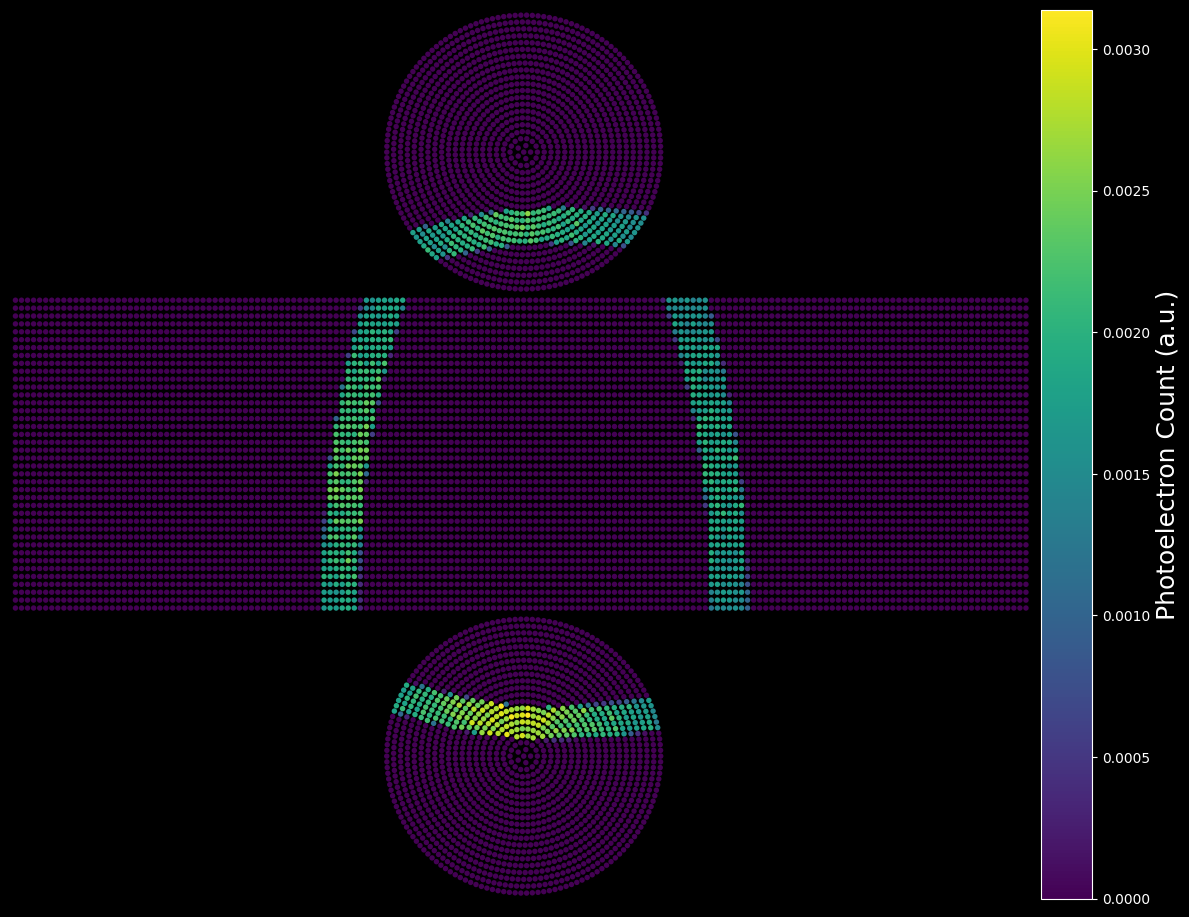

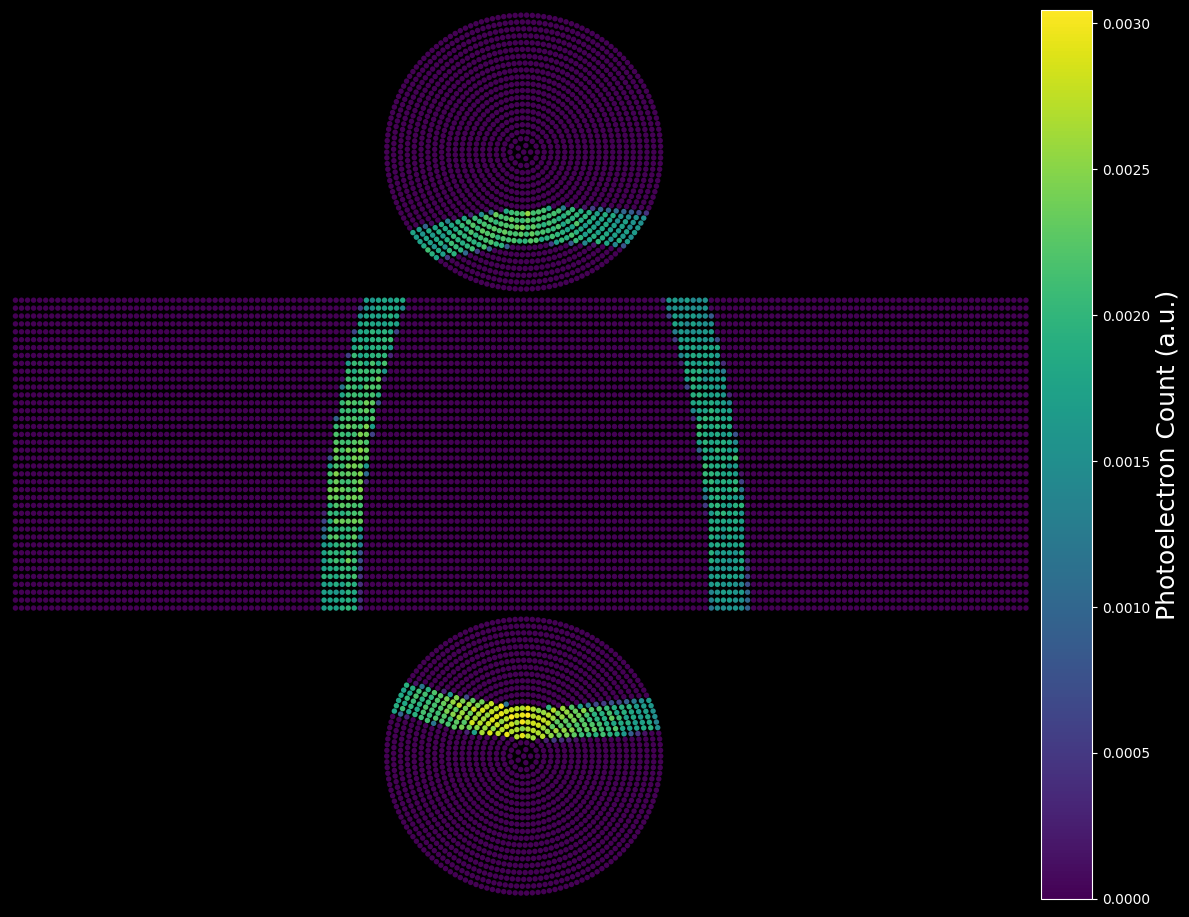

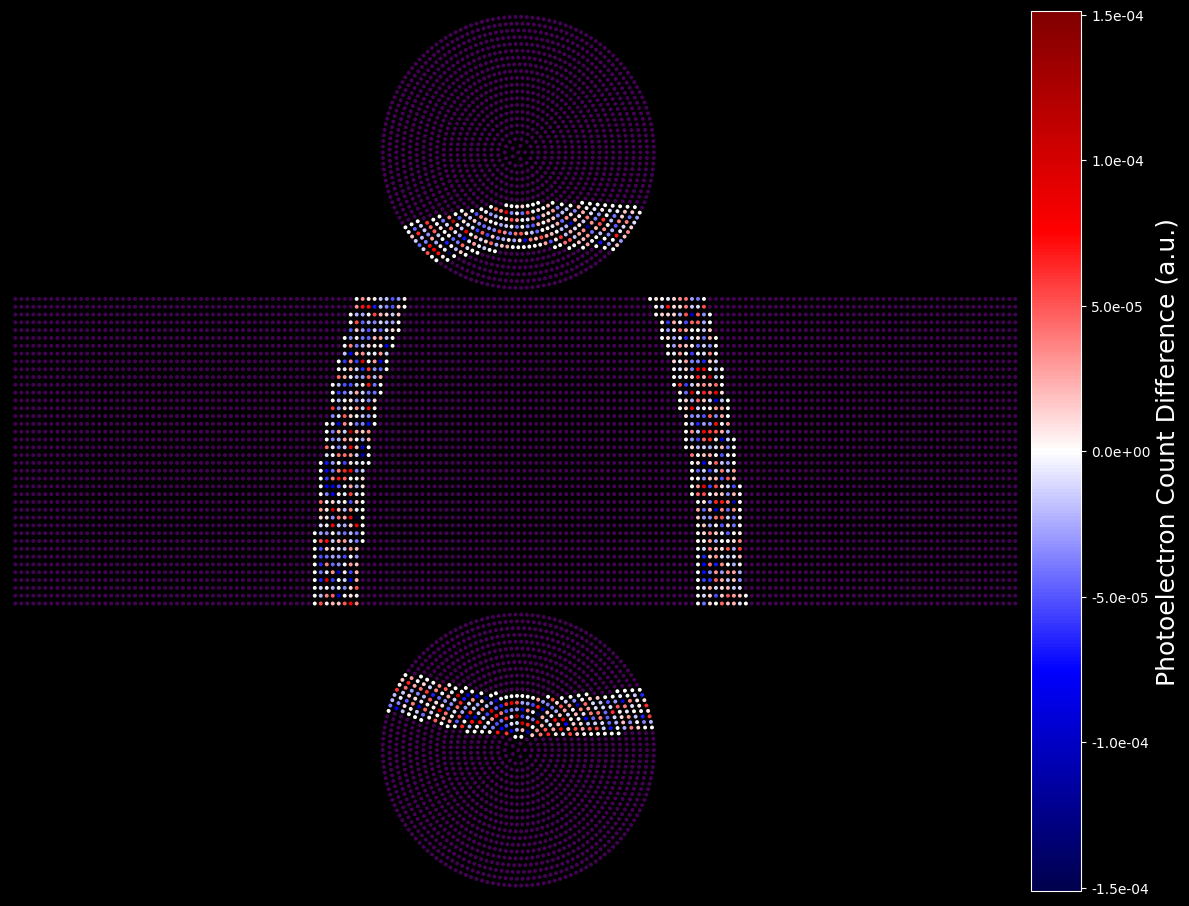

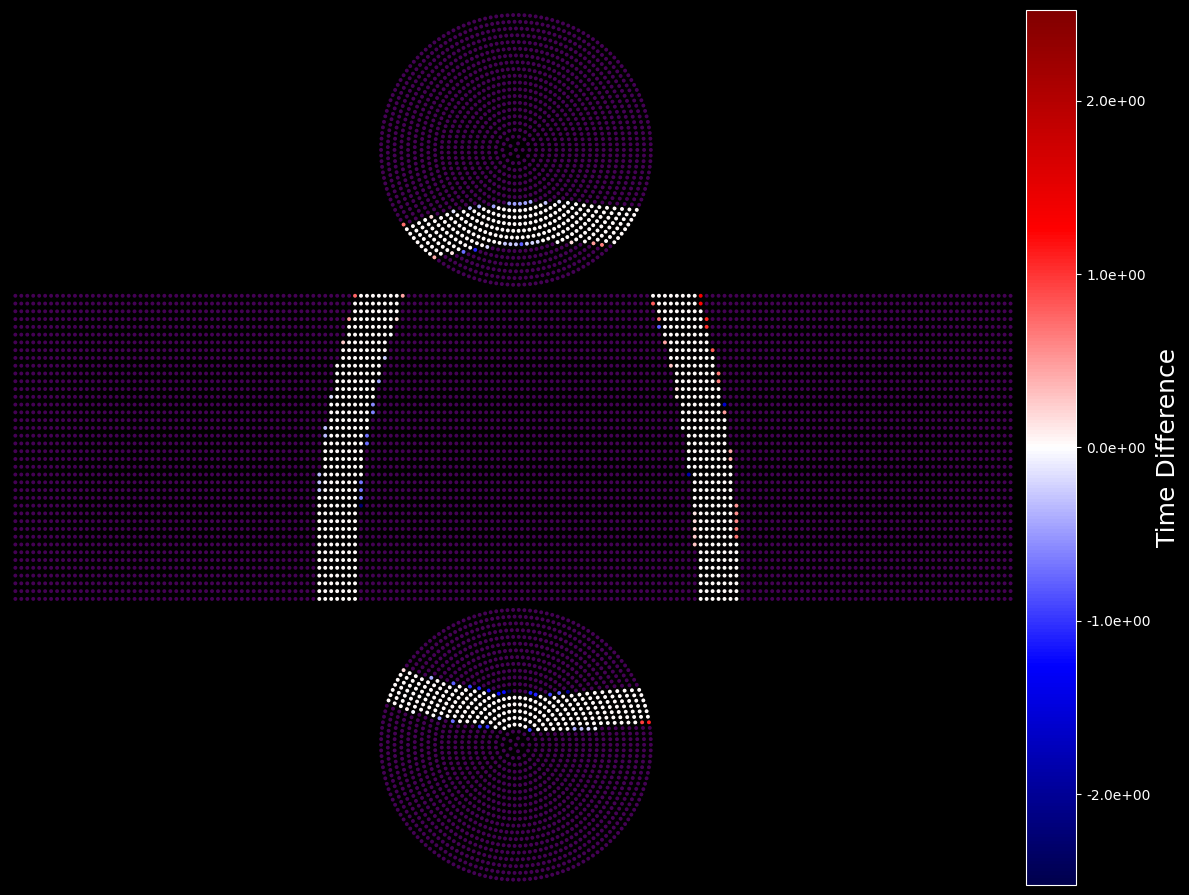

Average charge difference: 2.644435880938545e-05
Normalized average charge difference: 0.00842502061277628
Average time difference: -5.4280935302131184e-08
Normalized average time difference: -2.174114044350972e-08


In [21]:
# Evaluate Relaxation Difference

from tools.visualization import create_detector_comparison_display
from tools.utils import sparse_to_full, load_single_event, full_to_sparse

default_json_filename = 'config/cyl_geom_config.json'

detector = generate_detector(default_json_filename)
detector_points = jnp.array(detector.all_points)
detector_radius = detector.S_radius
NUM_DETECTORS = len(detector_points)
Nphot = 1_000_000

# Generate events with same parameters but different temperatures
key = jax.random.PRNGKey(7109090)

# Use your existing parameter configuration
true_params = generate_random_params(key)

# Generate events
event_data = simulate_true_data(true_params, key)
event_sim = simulate_event(true_params, key)

# Create regular displays for both temperatures
detector_display = create_detector_display(sparse=False)

# Display individual events
detector_display(*event_data, file_name='temp1_display.png', plot_time=False)
detector_display(*event_sim, file_name='temp2_display.png', plot_time=False)

# Create comparison display
detector_comparison = create_detector_comparison_display(sparse=False)

# Display differences with time alignment
detector_comparison(event_data, event_sim, file_name='temp_comparison_charge.png', plot_time=False)
detector_comparison(event_data, event_sim, file_name='temp_comparison_time.png', plot_time=True, align_time=True)

indices1, charges1, times1 = full_to_sparse(*event_data)
indices2, charges2, times2 = full_to_sparse(*event_sim)

# If you want to calculate averages of differences
charges_full1 = sparse_to_full(indices1, charges1, NUM_DETECTORS)
charges_full2 = sparse_to_full(indices2, charges2, NUM_DETECTORS)
charge_diff = charges_full2 - charges_full1
charge_diff_avg = jnp.mean(jnp.abs(charge_diff[charge_diff != 0]))

# Calculate time differences with alignment
times_full1 = sparse_to_full(indices1, times1, NUM_DETECTORS)
times_full2 = sparse_to_full(indices2, times2, NUM_DETECTORS)
active_times1 = times_full1 > 0
active_times2 = times_full2 > 0
times1_mean = jnp.mean(times_full1[active_times1])
times2_mean = jnp.mean(times_full2[active_times2])
times_aligned1 = jnp.where(active_times1, times_full1 - times1_mean, 0)
times_aligned2 = jnp.where(active_times2, times_full2 - times2_mean, 0)
time_diff = times_aligned2 - times_aligned1
time_diff_avg = jnp.mean(time_diff[time_diff != 0])

print(f'Average charge difference: {charge_diff_avg}')
print(f"Normalized average charge difference: {charge_diff_avg/jnp.max(charges_full1)}")
print(f'Average time difference: {time_diff_avg}')
print(f'Normalized average time difference: {time_diff_avg/jnp.max(times_full1)}')

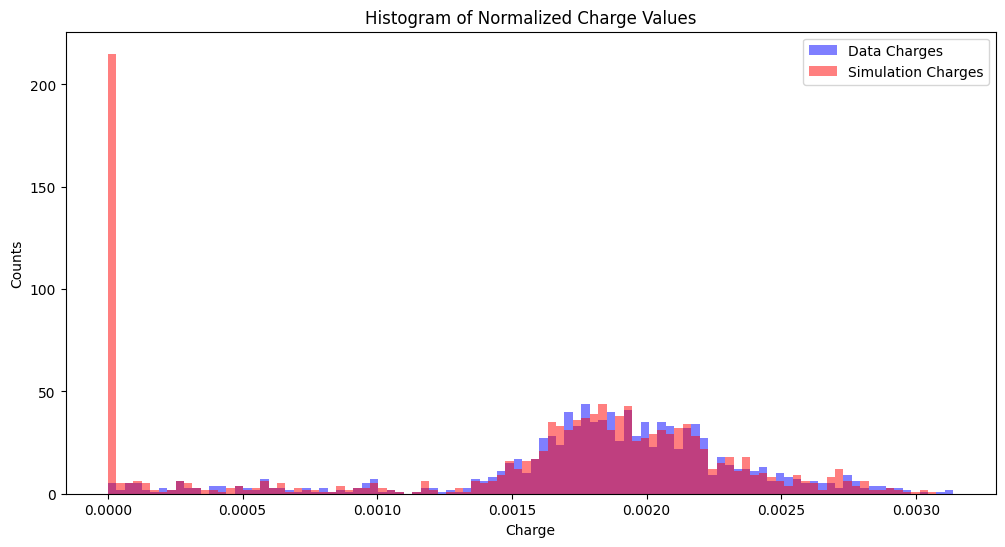

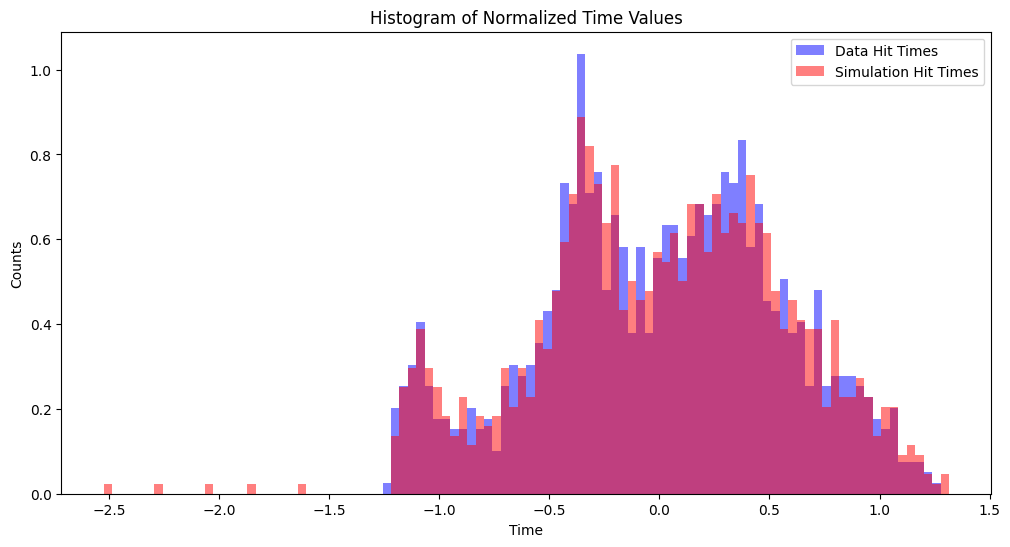

In [22]:
from matplotlib import pyplot as plt

# plot histogram of charges
plt.figure(figsize=(12, 6))

range_values = (jnp.min(jnp.concatenate([charges1, charges2])), jnp.max(jnp.concatenate([charges1, charges2])))
plt.hist(charges1, bins=100, alpha=0.5, label='Data Charges', color='b', range=range_values)
plt.hist(charges2, bins=100, alpha=0.5, label='Simulation Charges', color='r', range=range_values)
plt.xlabel('Charge')
plt.ylabel('Counts')
plt.title('Histogram of Normalized Charge Values')
plt.legend()
plt.show()

# plot histogram of times
plt.figure(figsize=(12, 6))

range_values = (jnp.min(jnp.concatenate([times_aligned1, times_aligned2])), jnp.max(jnp.concatenate([times_aligned1, times_aligned2])))
plt.hist(times_aligned1[jnp.abs(times_aligned1)>0], bins=100, alpha=0.5, label='Data Hit Times', color='b', range=range_values, density=True)
plt.hist(times_aligned2[jnp.abs(times_aligned2)>0], bins=100, alpha=0.5, label='Simulation Hit Times', color='r', range=range_values, density=True)
plt.xlabel('Time')
plt.ylabel('Counts')
plt.title('Histogram of Normalized Time Values')
plt.legend()
plt.show()

[-0.03593181  0.05765054  0.03100547 -0.04216397 -0.04311005 -0.08429489
 -0.15033495 -0.1032408   0.00914174  0.02661013 -0.00182402 -0.00285827
 -0.01200611 -0.04763975 -0.10769596 -0.07265589 -0.0163764  -0.03911221
 -0.04790426  0.00551456 -0.01117574 -0.03807146 -0.06070957 -0.07328473
 -0.03290045 -0.02833241 -0.02825356 -0.05140976 -0.0418735  -0.04989966
 -0.0489997  -0.03521083 -0.0252811  -0.02916203 -0.03528693 -0.05755844
 -0.07518158 -0.05519923 -0.03725229 -0.01725207 -0.01933006 -0.04271894
 -0.05865622 -0.04426079 -0.04008313 -0.04637376 -0.03721078 -0.05658482
 -0.04211484 -0.03321672 -0.04341136 -0.03643883 -0.0392269  -0.05644297
 -0.06629243 -0.05392895 -0.02234987 -0.02976984 -0.03805036 -0.04776635
 -0.04844568 -0.04707119 -0.05307794 -0.05669233 -0.04198055 -0.03942112
 -0.03871316 -0.04004805 -0.04612195 -0.04114058 -0.04211789 -0.03733676
 -0.03808242 -0.04410655 -0.04587703 -0.04554209 -0.03922771 -0.03649206
 -0.02487737 -0.02647172 -0.02697278 -0.03145869 -0

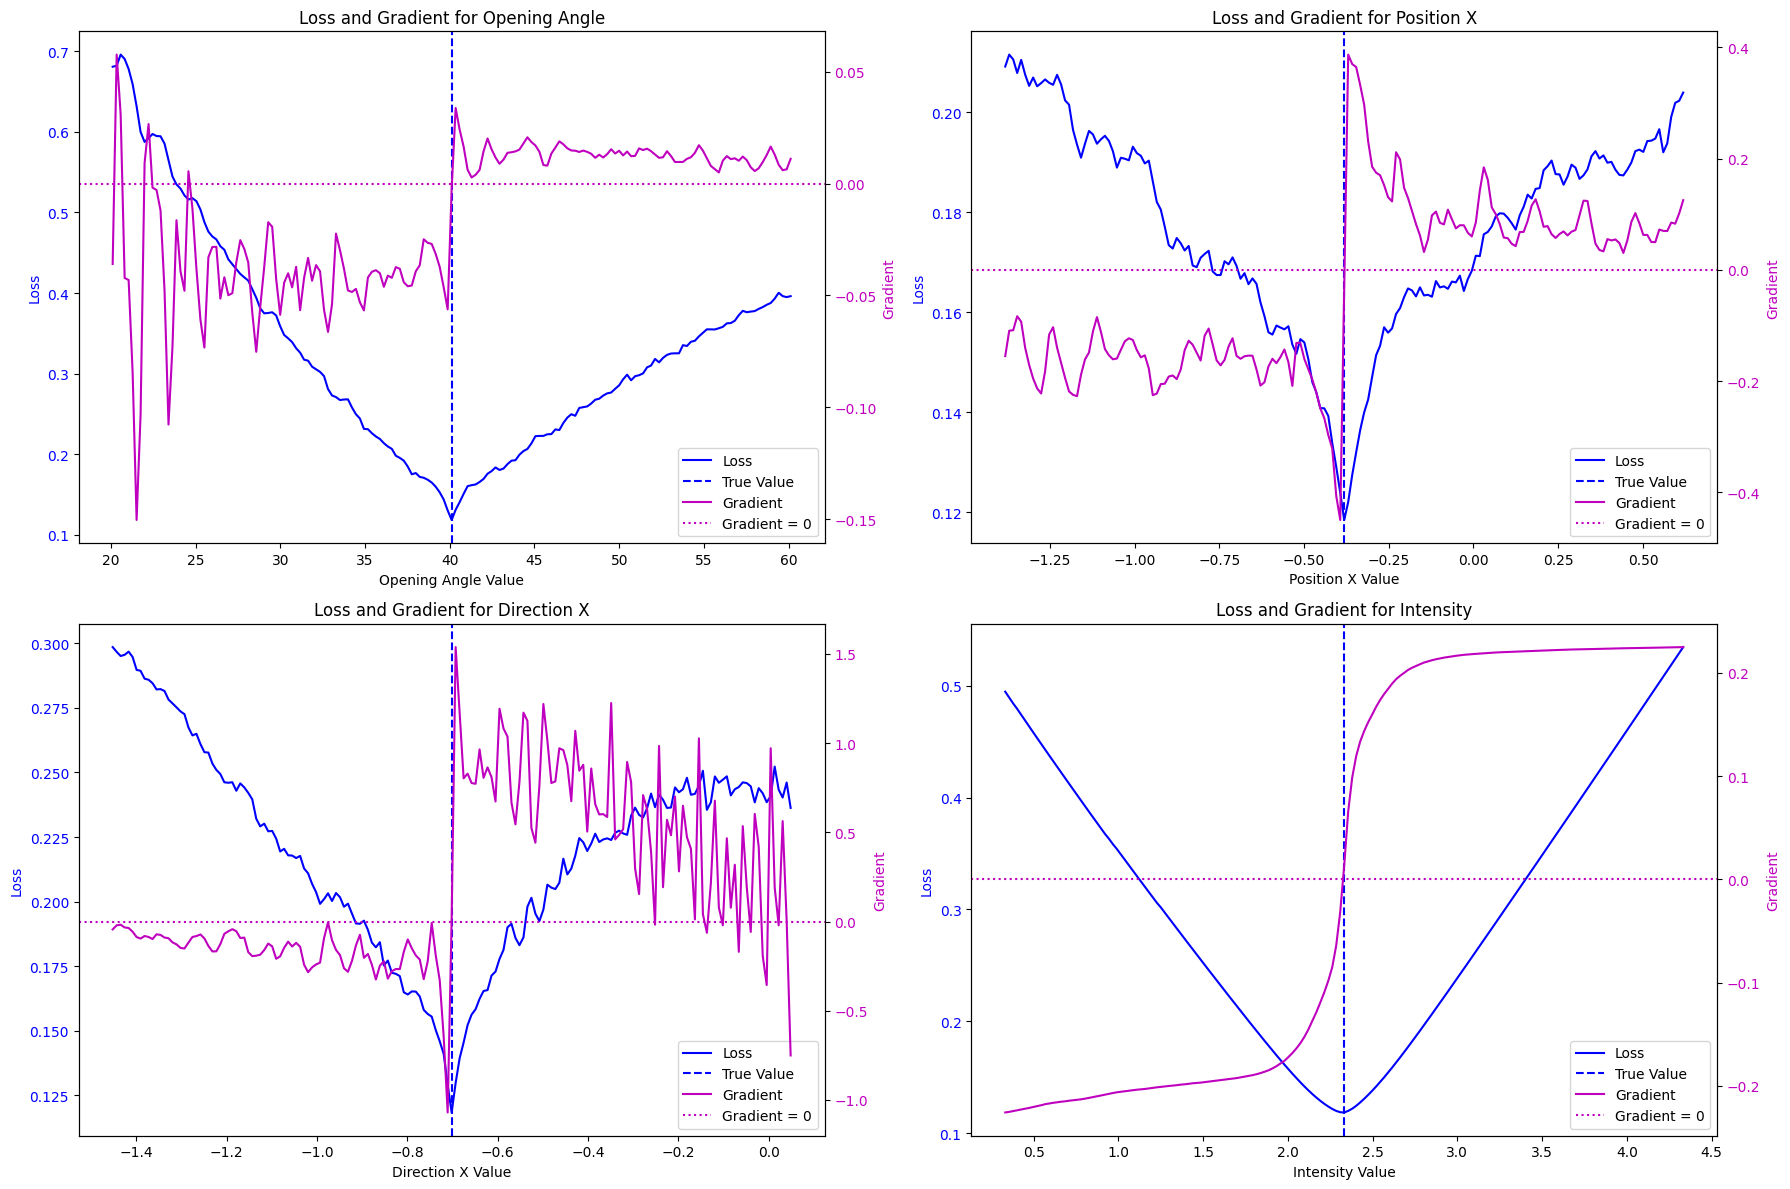

In [24]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad
import matplotlib.pyplot as plt

# True parameters
true_params = (
    jnp.array(40.0),  # opening angle
    jnp.array([0.5, 0.0, 1.0]),  # position
    jnp.array([0.0, 1.0, 0.0]),  # direction
    jnp.array(5.0)  # intensity
)

# true_params = (28.0, Array([-0.43781567, -0.73624456,  0.8653257 ], dtype=float32), Array([-0.22711356,  0.8828953 ,  0.35990906], dtype=float32), 4.334892272949219)

# true_params = (
#     jnp.array(28.0),  # opening angle
#     jnp.array([-0.43781567, -0.73624456,  0.8653257]),  # position
#     jnp.array([-0.22711356,  0.8828953 ,  0.35990906]),  # direction
#     jnp.array(4.334892272949219)  # intensity
# )

# Parameter changes
param_changes = (
    jnp.array(20.0),  # opening angle
    jnp.array([1.0, 0.0, 0.0]),  # position (only changing first component)
    jnp.array([0.75, 0.0, 0.0]),  # direction (only changing first component)
    jnp.array(2.0)  # intensity
)

# Generate true data (without gradients)
key = jax.random.PRNGKey(1059080)

true_params = generate_random_params(key)

true_data_temp = jax.lax.stop_gradient(simulate_true_data(true_params, key))

# save data
save_single_event(true_data_temp, true_params, filename='events/true_event_data.h5')

# load data, first element is true_params
true_data = load_single_event('events/true_event_data.h5', NUM_DETECTORS, sparse=False)[1:]

temperature_sim = 0.2
simulate_event = setup_event_simulator(default_json_filename, Nphot, temperature_sim)

def generate_param_ranges(true_params, param_changes, num_points=201):
    param_ranges = []
    for i, (true_param, change) in enumerate(zip(true_params, param_changes)):
        if i in [1, 2]:  # position and direction
            start = true_param[0] - change[0]
            end = true_param[0] + change[0]
        else:  # opening angle and intensity
            start = true_param - change
            end = true_param + change
        param_ranges.append(jnp.linspace(start, end, num_points))
    return param_ranges

@jit
def loss_and_grad(params):
    def loss_fn(params):
        simulated_data = simulate_event(params, key)
        return compute_loss_with_time(detector_points, *true_data, *simulated_data)
    return value_and_grad(loss_fn)(params)

def generate_plot_data(param_index, param_values):
    losses = []
    gradients = []

    for new_value in param_values:
        new_params = list(true_params)
        if param_index in [1, 2]:  # position and direction
            new_params[param_index] = new_params[param_index].at[0].set(new_value)
        else:  # opening angle and intensity
            new_params[param_index] = new_value
            
        new_params = tuple(new_params)

        loss, grad = loss_and_grad(new_params)
        gradient = grad[param_index]
        if param_index in [1, 2]:
            gradient = gradient[0]

        losses.append(loss)
        gradients.append(gradient)

    return jnp.array(losses), jnp.array(gradients)

# Generate parameter ranges
num_points = 171
param_ranges = generate_param_ranges(true_params, param_changes, num_points)

# Plot results
fig, axs = plt.subplots(2, 2, figsize=(18, 12))
param_names = ['Opening Angle', 'Position X', 'Direction X', 'Intensity']

for i, (row, col) in enumerate([(0, 0), (0, 1), (1, 0), (1, 1)]):
    param_values = param_ranges[i]
    losses, gradients = generate_plot_data(i, param_values)

    print(gradients)
    
    ax1 = axs[row, col]
    ax2 = ax1.twinx()
    
    ax1.plot(param_values, losses, 'b-', label='Loss')
    ax2.plot(param_values, gradients, 'm-', label='Gradient')
    
    # Add vertical line at the center (true parameter value)
    true_value = true_params[i] if i not in [1, 2] else true_params[i][0]
    ax1.axvline(x=true_value, color='b', linestyle='--', label='True Value')
    
    # Add horizontal line for gradient at zero
    ax2.axhline(y=0, color='m', linestyle=':', label='Gradient = 0')
    
    ax1.set_xlabel(f'{param_names[i]} Value')
    ax1.set_ylabel('Loss', color='b')
    ax2.set_ylabel('Gradient', color='m')
    
    ax1.tick_params(axis='y', labelcolor='b')
    ax2.tick_params(axis='y', labelcolor='m')
    
    ax1.set_title(f'Loss and Gradient for {param_names[i]}')
    
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right')

plt.tight_layout()
plt.show()

In [25]:
# 2D Valley Analysis
# This is the case where we move closer to the wall and increase the opening angle. The gradient is the steepest in the direction of the valley.

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad
import matplotlib.pyplot as plt

# True parameters
true_params = (
    jnp.array(40.0),  # opening angle
    jnp.array([0.0, 0.0, 0.0]),  # position
    jnp.array([1.0, 0.0, 0.0]),  # direction
    jnp.array(5.0)  # intensity
)

# key = jax.random.PRNGKey(1)
# 
# true_params = generate_random_params(jax.random.PRNGKey(1))

# Parameter changes
param_changes = (
    jnp.array(5.0),  # opening angle
    jnp.array([0.5, 0.0, 0.0]),  # position (only changing first component)
    jnp.array([0.25, 0.0, 0.0]),  # direction (only changing first component)
    jnp.array(2.0)  # intensity
)

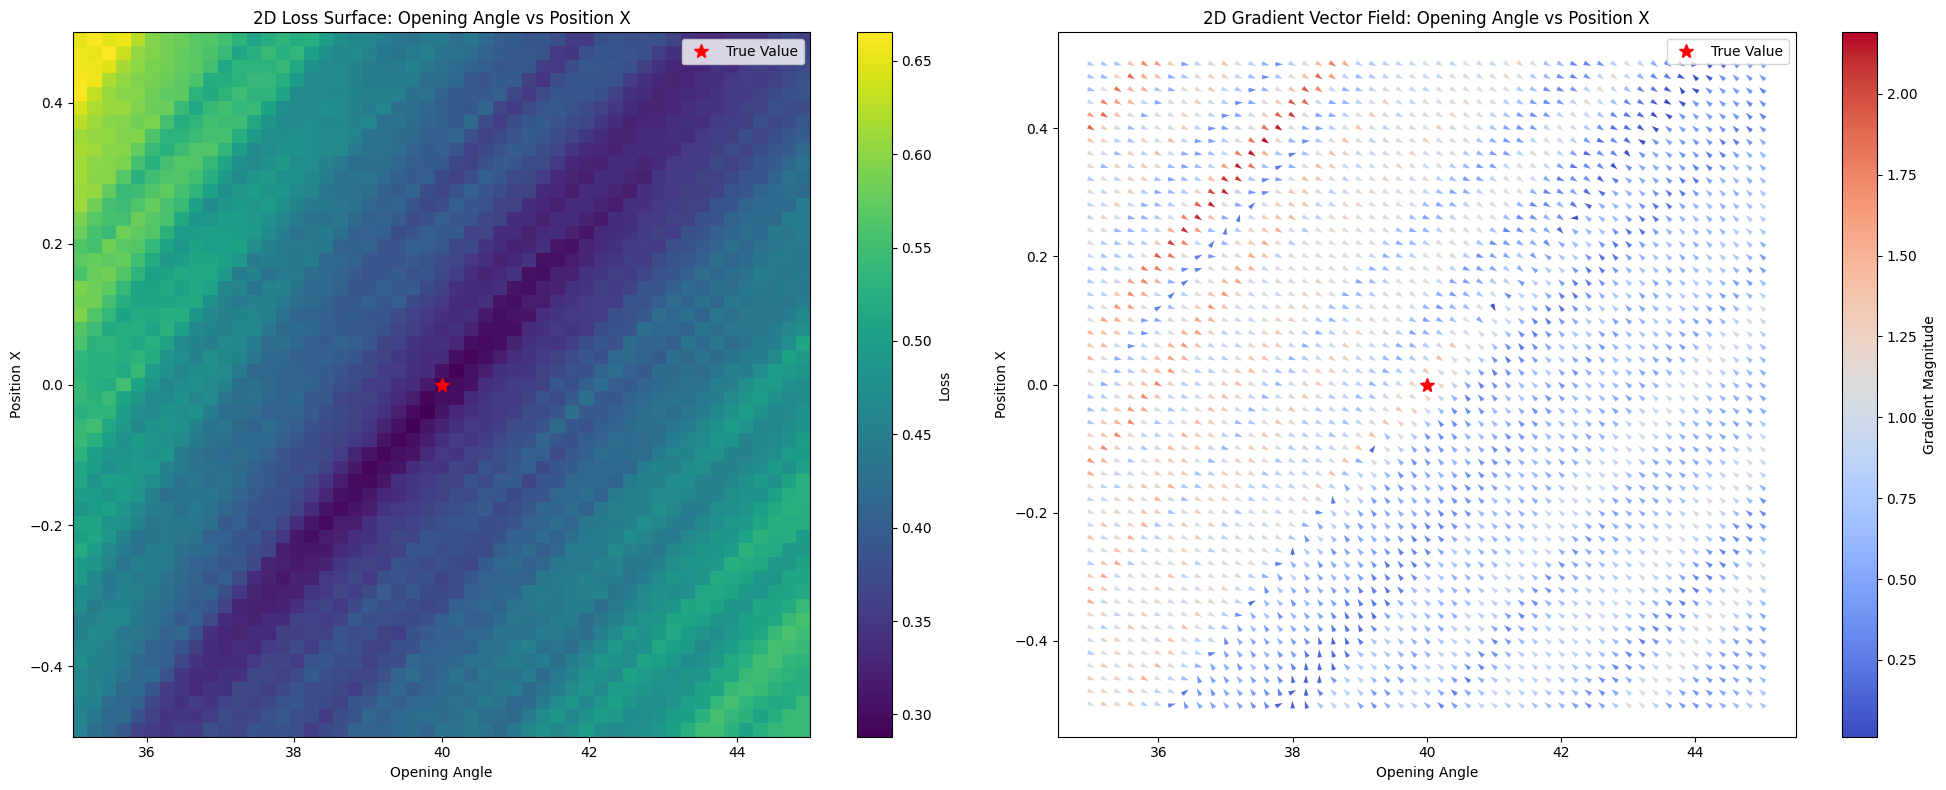

In [26]:
# Gradient scales
gradient_scales = jnp.array([0.1, 1, 5, 0.5])
# gradient_scales = jnp.array([1.0, 1.0, 1.0, 1.0])

# Generate true data (without gradients)
key = jax.random.PRNGKey(1)
true_data = jax.lax.stop_gradient(simulate_true_data(true_params, key))

true_data = (true_data[0], true_data[1])

def generate_param_ranges(true_params, param_changes, num_points=51):
    param_ranges = []
    for i, (true_param, change) in enumerate(zip(true_params, param_changes)):
        if i in [1, 2]:  # position and direction
            start = true_param[0] - change[0]
            end = true_param[0] + change[0]
        else:  # opening angle and intensity
            start = true_param - change
            end = true_param + change
        param_ranges.append(jnp.linspace(start, end, num_points))
    return param_ranges

@jit
def loss_and_grad(params):
    def loss_fn(params):
        simulated_data = simulate_event(params, key)
        return compute_loss_with_time(detector_points, *true_data, *simulated_data)
    return value_and_grad(loss_fn)(params)

def generate_2d_plot_data(param_index1, param_index2, param_values1, param_values2):
    losses = jnp.zeros((len(param_values1), len(param_values2)))
    gradients = jnp.zeros((len(param_values1), len(param_values2), 2))

    for i, value1 in enumerate(param_values1):
        for j, value2 in enumerate(param_values2):
            new_params = list(true_params)

            if param_index1 in [1, 2]:
                new_params[param_index1] = new_params[param_index1].at[0].set(value1)
            else:
                new_params[param_index1] = value1

            if param_index2 in [1, 2]:
                new_params[param_index2] = new_params[param_index2].at[0].set(value2)
            else:
                new_params[param_index2] = value2

            new_params = tuple(new_params)

            loss, grad = loss_and_grad(new_params)
            gradient1 = grad[param_index1][0] if param_index1 in [1, 2] else grad[param_index1]
            gradient2 = grad[param_index2][0] if param_index2 in [1, 2] else grad[param_index2]

            # Rescale gradients
            gradient1 /= gradient_scales[param_index1]
            gradient2 /= gradient_scales[param_index2]

            losses = losses.at[i, j].set(loss)
            gradients = gradients.at[i, j].set(jnp.array([gradient1, gradient2]))

    return losses, gradients

# Generate parameter ranges
num_points = 51
param_ranges = generate_param_ranges(true_params, param_changes, num_points)

# Choose two parameters to vary (e.g., opening angle and intensity)
param_index1, param_index2 = 0, 1
param_names = ['Opening Angle', 'Position X', 'Direction X', 'Intensity']

# Generate 2D plot data
losses, gradients = generate_2d_plot_data(param_index1, param_index2, param_ranges[param_index1], param_ranges[param_index2])

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot 2D loss surface
im = ax1.imshow(losses.T, extent=[param_ranges[param_index1][0], param_ranges[param_index1][-1],
                                  param_ranges[param_index2][0], param_ranges[param_index2][-1]],
                origin='lower', aspect='auto', cmap='viridis')
ax1.set_title(f'2D Loss Surface: {param_names[param_index1]} vs {param_names[param_index2]}')
ax1.set_xlabel(param_names[param_index1])
ax1.set_ylabel(param_names[param_index2])
fig.colorbar(im, ax=ax1, label='Loss')

# Plot 2D gradient vector field
X, Y = jnp.meshgrid(param_ranges[param_index1], param_ranges[param_index2])
U = -1 * gradients[:, :, 0].T
V = -1 * gradients[:, :, 1].T

# Normalize gradients for better visualization
norm = jnp.sqrt(U**2 + V**2)
U_norm = U / norm
V_norm = V / norm

ax2.quiver(X, Y, U_norm, V_norm, norm, cmap='coolwarm', pivot='mid')
ax2.set_title(f'2D Gradient Vector Field: {param_names[param_index1]} vs {param_names[param_index2]}')
ax2.set_xlabel(param_names[param_index1])
ax2.set_ylabel(param_names[param_index2])
fig.colorbar(ax2.collections[0], ax=ax2, label='Gradient Magnitude')

# Add markers for true parameter values
true_value1 = true_params[param_index1] if param_index1 not in [1, 2] else true_params[param_index1][0]
true_value2 = true_params[param_index2] if param_index2 not in [1, 2] else true_params[param_index2][0]
ax1.plot(true_value1, true_value2, 'r*', markersize=10, label='True Value')
ax2.plot(true_value1, true_value2, 'r*', markersize=10, label='True Value')

ax1.legend()
ax2.legend()

plt.tight_layout()
plt.show()

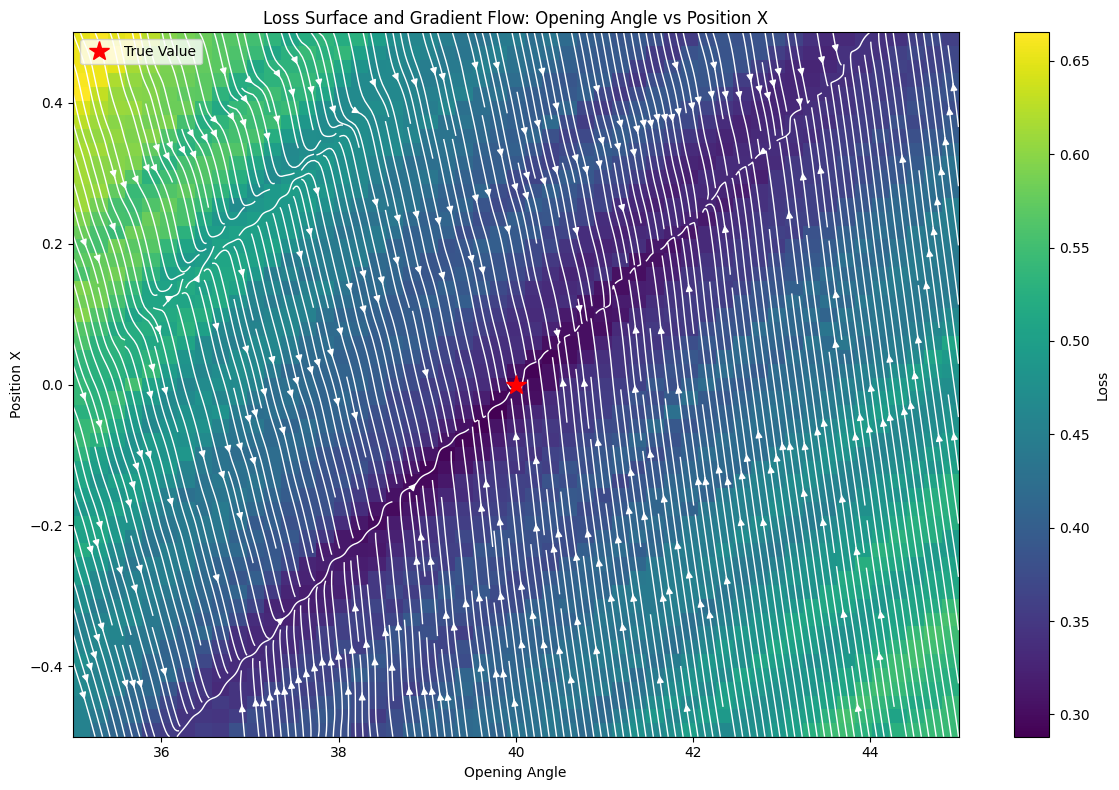

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Create a single plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot 2D loss surface
im = ax.imshow(losses.T, extent=[param_ranges[param_index1][0], param_ranges[param_index1][-1],
                               param_ranges[param_index2][0], param_ranges[param_index2][-1]],
              origin='lower', aspect='auto', cmap='viridis')
fig.colorbar(im, ax=ax, label='Loss')

# Create equally spaced arrays for streamplot
x = np.linspace(param_ranges[param_index1][0], param_ranges[param_index1][-1], len(param_ranges[param_index1]))
y = np.linspace(param_ranges[param_index2][0], param_ranges[param_index2][-1], len(param_ranges[param_index2]))
X, Y = np.meshgrid(x, y)

# Prepare gradient data
U = -1 * gradients[:, :, 0].T
V = -1 * gradients[:, :, 1].T

# Normalize gradients for better visualization
norm = np.sqrt(U**2 + V**2)
U_norm = U / norm
V_norm = V / norm

# Add streamplot on top of loss surface
strm = ax.streamplot(X, Y, U_norm, V_norm, 
                    color='white',  # Using white for visibility
                    density=4,      # Adjust density of streamlines
                    linewidth=1,    # Adjust line width
                    arrowsize=1)    # Adjust arrow size

# Add marker for true parameter value
true_value1 = true_params[param_index1] if param_index1 not in [1, 2] else true_params[param_index1][0]
true_value2 = true_params[param_index2] if param_index2 not in [1, 2] else true_params[param_index2][0]
ax.plot(true_value1, true_value2, 'r*', markersize=15, label='True Value')

# Set title and labels
ax.set_title(f'Loss Surface and Gradient Flow: {param_names[param_index1]} vs {param_names[param_index2]}')
ax.set_xlabel(param_names[param_index1])
ax.set_ylabel(param_names[param_index2])
ax.legend()

plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


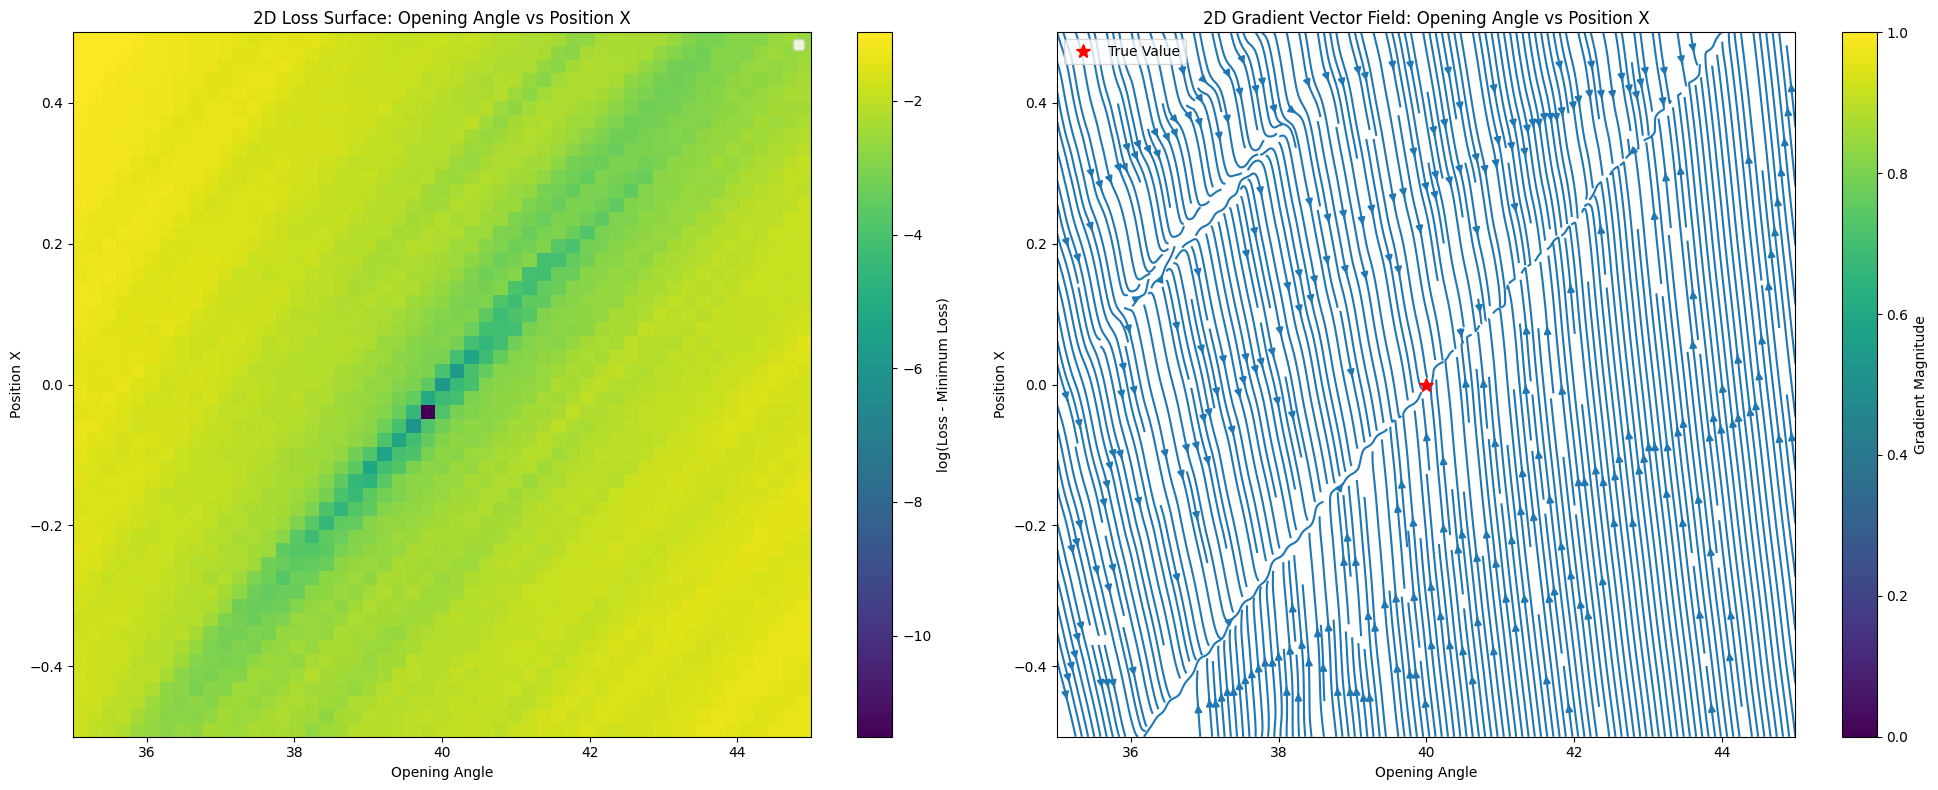

In [28]:
import numpy as np

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot 2D loss surface
im = ax1.imshow(np.log(losses.T-np.min(losses)+1e-5), extent=[param_ranges[param_index1][0], param_ranges[param_index1][-1],
                                  param_ranges[param_index2][0], param_ranges[param_index2][-1]],
                origin='lower', aspect='auto', cmap='viridis')
ax1.set_title(f'2D Loss Surface: {param_names[param_index1]} vs {param_names[param_index2]}')
ax1.set_xlabel(param_names[param_index1])
ax1.set_ylabel(param_names[param_index2])
fig.colorbar(im, ax=ax1, label='log(Loss - Minimum Loss)')

# Plot 2D gradient vector field
X, Y = jnp.meshgrid(param_ranges[param_index1], param_ranges[param_index2])

# Create equally spaced arrays
x = np.linspace(param_ranges[param_index1][0], param_ranges[param_index1][-1], len(param_ranges[param_index1]))
y = np.linspace(param_ranges[param_index2][0], param_ranges[param_index2][-1], len(param_ranges[param_index2]))

# Generate meshgrid
X, Y = np.meshgrid(x, y)

U = -1 * gradients[:, :, 0].T
V = -1 * gradients[:, :, 1].T

# Normalize gradients for better visualization
norm = jnp.sqrt(U**2 + V**2)
U_norm = U / norm
V_norm = V / norm

# ax2.quiver(X, Y, U_norm, V_norm, norm, cmap='coolwarm', pivot='mid')
ax2.streamplot(X, Y, U_norm, V_norm, norm=norm, cmap='coolwarm', density = 4)
ax2.set_title(f'2D Gradient Vector Field: {param_names[param_index1]} vs {param_names[param_index2]}')
ax2.set_xlabel(param_names[param_index1])
ax2.set_ylabel(param_names[param_index2])
fig.colorbar(ax2.collections[0], ax=ax2, label='Gradient Magnitude')

# Add markers for true parameter values
true_value1 = true_params[param_index1] if param_index1 not in [1, 2] else true_params[param_index1][0]
true_value2 = true_params[param_index2] if param_index2 not in [1, 2] else true_params[param_index2][0]
# ax1.plot(true_value1, true_value2, 'r*', markersize=10, label='True Value')
ax2.plot(true_value1, true_value2, 'r*', markersize=10, label='True Value')

ax1.legend()
ax2.legend()

plt.tight_layout()
plt.show()